In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings

/Users/heyueqi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1. Load Processed Data (feature engineering; 24h; aggregation)

In [2]:
TIME_WINDOW_IN_HOUR = 72
df_agg = pd.read_csv(f'../../data/mimic_dataset_{TIME_WINDOW_IN_HOUR}h_aggregated.csv')
df_agg.head()

,gender,age,elixhauser,re_admission,Height_cm,Weight_kg,mechvent_mean,mechvent_max,extubated_mean,extubated_max,...,SIRS_min,SIRS_max,SIRS_std,SIRS_last,time_to_discharge_mean,time_to_discharge_min,time_to_discharge_max,time_to_discharge_std,time_to_discharge_last,died_in_hosp
0,1,82,3,0,175.00,80.0,0.631579,1,0.052632,1,...,1,3,0.696692,1,273600.0,273600,273600,0.0,273600,0
1,1,30,7,0,172.72,56.8,0.000000,0,0.000000,0,...,2,4,0.333333,3,273600.0,273600,273600,0.0,273600,0
2,1,47,1,0,167.64,62.8,0.368421,1,0.157895,1,...,1,4,0.768533,2,273600.0,273600,273600,0.0,273600,0
3,1,43,9,1,172.72,66.6,1.000000,1,0.000000,0,...,0,4,1.228321,1,273600.0,273600,273600,0.0,273600,0
4,1,53,8,0,155.00,47.5,1.000000,1,0.000000,0,...,1,4,0.653376,3,273600.0,273600,273600,0.0,273600,1


## 2. Define X and y

In [3]:
target_col = 'died_in_hosp'
y = df_agg[target_col].astype(int)
X = df_agg.drop(columns=[target_col])

In [4]:
print(f"class distribution:")
print(f"  died patients (1): {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")
print(f"  survived patients (0): {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")

class distribution:
  died patients (1): 589 (21.0%)
  survived patients (0): 2215 (79.0%)


## 3. Data Splitting  
- Divide the dataset into the training set and the test set, with an 80/20 ratio.
- To ensure that the proportion of deceased/survived patients in the training set and the test set is consistent with the original data, `stratified sampling` is adopted.

In [5]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=42, 
    stratify=y
)

print(f"Size of the training set: {X_train.shape}")
print(f"Size of the testing set: {X_test.shape}")
print(f"Training set mortality rate: {y_train.mean():.3f}")
print(f"Testing set mortality rate: {y_test.mean():.3f}")

Size of the training set: (2243, 330)
Size of the testing set: (561, 330)
Training set mortality rate: 0.210
Testing set mortality rate: 0.210


## 4. Missing Value Imputation

- For missing values, the **MICE (Multiple Imputation by Chained Equations)** method is used. This approach iteratively predicts missing values for each feature using other features in the dataset, making it more robust and accurate compared to simple imputation methods like mean or median.

- The imputation model is fitted only on the training set and then applied to both the training and testing sets to prevent data leakage.

- MICE is particularly effective when there are complex relationships between features or when multiple features have missing values.

In [6]:
print(f"Proportion of missing values:")
missing_proportion = (X.isnull().sum()/X.shape[0]).sort_values(ascending=False) 
print(missing_proportion)

Proportion of missing values:
ETCO2_std                 0.044936
ETCO2_min                 0.044579
ETCO2_max                 0.044579
ETCO2_last                0.044579
ETCO2_mean                0.044579
                            ...   
PAWpeak_last              0.000000
PAWpeak_std               0.000000
PAWpeak_max               0.000000
PAWpeak_min               0.000000
time_to_discharge_last    0.000000
Length: 330, dtype: float64


In [7]:
imputer = IterativeImputer(max_iter=10, random_state=42)

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

## 5. Feature Scaling    
    
Random Forest doesn't need feature scaling (tree-based models are scale-invariant)

## 6. Random Forest Training and Hyperparameter Tuning

In [8]:
def objective(trial):
    """
    Optuna objective function for Random Forest hyperparameter optimization.
    Uses StratifiedKFold cross-validation and evaluates using AUCPR with overfitting penalty
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7]),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.01),  # regularization to reduce overfitting
        'max_samples': trial.suggest_float('max_samples', 0.6, 1.0),  # bootstrap sampling
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': 'balanced',  # imbalanced data handling
        'bootstrap': True,
        'oob_score': True,  # Out-of-bag score
        'random_state': 42,
        'n_jobs': -1
    }
    
    # StratifiedKFold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_auc = []
    cv_scores_aucpr = []  # AUCPR is more relevant for imbalanced data
    train_scores = []  # monitor training performance for overfitting analysis
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_imputed, y_train)):
        X_fold_train = X_train_imputed[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train_imputed[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        model = RandomForestClassifier(**params)
        
        model.fit(X_fold_train, y_fold_train)
        
        y_train_proba = model.predict_proba(X_fold_train)[:, 1]
        y_val_proba = model.predict_proba(X_fold_val)[:, 1]
        
        train_auc = roc_auc_score(y_fold_train, y_train_proba)
        val_auc = roc_auc_score(y_fold_val, y_val_proba)
        val_aucpr = average_precision_score(y_fold_val, y_val_proba)  # main metric
        
        train_scores.append(train_auc)
        cv_scores_auc.append(val_auc)
        cv_scores_aucpr.append(val_aucpr)
        
        # Optuna pruning
        trial.report(val_aucpr, fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    mean_cv_auc = np.mean(cv_scores_auc)
    mean_cv_aucpr = np.mean(cv_scores_aucpr)
    mean_train_score = np.mean(train_scores)
    
    # overfitting peanlty
    overfitting_penalty = abs(mean_train_score - mean_cv_auc)
    if overfitting_penalty > 0.05:  # threshold: 5%
        mean_cv_aucpr -= overfitting_penalty * 0.5  
    
    trial.set_user_attr('mean_train_auc', mean_train_score)
    trial.set_user_attr('mean_val_auc', mean_cv_auc)
    trial.set_user_attr('mean_val_aucpr', mean_cv_aucpr)
    trial.set_user_attr('overfitting_gap', overfitting_penalty)
    
    return mean_cv_aucpr  

In [9]:
study = optuna.create_study(
    direction='maximize',  # maximize AUCPR
    sampler=optuna.samplers.TPESampler(seed=42),  # TPE sampler
    pruner=optuna.pruners.MedianPruner(  # Median pruner
        n_startup_trials=10,
        n_warmup_steps=2,
        interval_steps=1
    )
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-11-07 14:36:57,757] A new study created in memory with name: no-name-c07a5f1d-b3c5-4aa8-9811-4008b363efb5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 14:37:31,790] Trial 0 finished with value: 0.45304661470897817 and parameters: {'n_estimators': 400, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.5, 'min_impurity_decrease': 0.007080725777960455, 'max_samples': 0.608233797718321, 'criterion': 'gini'}. Best is trial 0 with value: 0.45304661470897817.
[I 2025-11-07 14:38:15,190] Trial 1 finished with value: 0.4480629891169321 and parameters: {'n_estimators': 300, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'min_impurity_decrease': 0.0029214464853521815, 'max_samples': 0.7465447373174767, 'criterion': 'entropy'}. Best is trial 0 with value: 0.45304661470897817.
[I 2025-11-07 14:38:58,071] Trial 2 finished with value: 0.44427343606786146 and parameters: {'n_estimators': 200, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 0.7, 'min_impurity_decrease': 0.008083973481164611, 'max_samples': 0.7218455076693483, 'criterio

In [10]:
best_params = study.best_params
best_score = study.best_value

print(f"best cross-validated AUCPR: {best_score:.4f}")
print(f"best parameters:")
for param, value in sorted(best_params.items()):
    print(f"  {param}: {value}")

best_trial = study.best_trial
print(f"\nbest trial details:")
print(f"  training set average AUC: {best_trial.user_attrs['mean_train_auc']:.4f}")
print(f"  test set average AUC: {best_trial.user_attrs['mean_val_auc']:.4f}")
print(f"  test set average AUCPR: {best_trial.user_attrs['mean_val_aucpr']:.4f}")
print(f"  Overfitting gap: {best_trial.user_attrs['overfitting_gap']:.4f}")


best cross-validated AUCPR: 0.4854
best parameters:
  criterion: gini
  max_depth: 12
  max_features: log2
  max_samples: 0.9997449754566207
  min_impurity_decrease: 0.008067722764459065
  min_samples_leaf: 7
  min_samples_split: 2
  n_estimators: 800

best trial details:
  training set average AUC: 0.8602
  test set average AUC: 0.7937
  test set average AUCPR: 0.4854
  Overfitting gap: 0.0665


In [11]:
best_model = RandomForestClassifier(
    class_weight='balanced',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    **best_params
)

best_rf = best_model.fit(X_train_imputed, y_train)

## 7. Model Evaluation

In [12]:
y_train_pred = best_rf.predict(X_train_imputed)
y_test_pred = best_rf.predict(X_test_imputed)
y_train_proba = best_rf.predict_proba(X_train_imputed)[:, 1]
y_test_proba = best_rf.predict_proba(X_test_imputed)[:, 1]

# Training set performance
print("Training set performance:")
train_auc = roc_auc_score(y_train, y_train_proba)
train_acc = best_rf.score(X_train_imputed, y_train)
train_auprc = average_precision_score(y_train, y_train_proba)
print(f"  Accuracy: {train_acc:.4f}")
print(f"  AUC-ROC: {train_auc:.4f}")
print(f"  AUPRC: {train_auprc:.4f}")
print(classification_report(y_train, y_train_pred))

# Test set performance
print("\nTest set performance:")
test_auc = roc_auc_score(y_test, y_test_proba)
test_acc = best_rf.score(X_test_imputed, y_test)
test_auprc = average_precision_score(y_test, y_test_proba)
print(f"  Accuracy: {test_acc:.4f}")
print(f"  AUC-ROC: {test_auc:.4f}")
print(f"  AUPRC: {test_auprc:.4f}")
print(classification_report(y_test, y_test_pred))


Training set performance:
  Accuracy: 0.7606
  AUC-ROC: 0.8412
  AUPRC: 0.5994
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1772
           1       0.46      0.73      0.56       471

    accuracy                           0.76      2243
   macro avg       0.69      0.75      0.70      2243
weighted avg       0.82      0.76      0.78      2243


Test set performance:
  Accuracy: 0.7255
  AUC-ROC: 0.7528
  AUPRC: 0.5121
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       443
           1       0.40      0.61      0.48       118

    accuracy                           0.73       561
   macro avg       0.64      0.68      0.65       561
weighted avg       0.78      0.73      0.74       561



In [13]:
# Overfitting check
print(f"\nOverfitting analysis:")
print(f"  Train-Test AUC difference: {(train_auc - test_auc):.4f}")
if train_auc - test_auc < 0.05:
    print(f"Low overfitting (difference < 0.05)")
elif train_auc - test_auc < 0.10:
    print(f"Mild overfitting (difference 0.05-0.10)")
else:
    print(f"Significant overfitting (difference > 0.10)")

# Confusion matrix
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(f"  True Negative (TN): {cm[0,0]}, False Positive (FP): {cm[0,1]}")
print(f"  False Negative (FN): {cm[1,0]}, True Positive (TP): {cm[1,1]}")

# Calculate additional metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])  # Recall/Sensitivity
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity
precision = cm[1,1] / (cm[1,1] + cm[0,1])    # Precision
npv = cm[0,0] / (cm[0,0] + cm[1,0])          # Negative Predictive Value

print(f"\nDetailed Performance Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.3f}")
print(f"  Specificity: {specificity:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Negative Predictive Value (NPV): {npv:.3f}")



Overfitting analysis:
  Train-Test AUC difference: 0.0883
Mild overfitting (difference 0.05-0.10)

Confusion Matrix (Test Set):
  True Negative (TN): 335, False Positive (FP): 108
  False Negative (FN): 46, True Positive (TP): 72

Detailed Performance Metrics:
  Sensitivity (Recall): 0.610
  Specificity: 0.756
  Precision: 0.400
  Negative Predictive Value (NPV): 0.879


In [14]:
with open(f'../results/{TIME_WINDOW_IN_HOUR}h_random_forest_result.txt', 'w') as f:
    f.write(f'Sample size: {X.shape[0]}\n')
    f.write(f'\nBest model: {best_rf}\n')
    
    f.write("\nTraining set performance:\n")
    f.write(f"    - Accuracy rate: {best_rf.score(X_train_imputed, y_train):.4f}\n")
    f.write(f"    - AUROC: {train_auc:.4f}\n")
    f.write(f"    - AUPRC: {average_precision_score(y_train, y_train_proba):.4f}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(y_train, y_train_pred))
    
    f.write("\nTesting set performance:\n")
    f.write(f"    - Accuracy rate: {best_rf.score(X_test_imputed, y_test):.4f}\n") 
    f.write(f"    - AUROC: {test_auc:.4f}\n")
    f.write(f"    - AUCPR: {test_auprc:.4f}\n")
    f.write("    - Classification Report:\n")
    f.write(classification_report(y_test, y_test_pred))
    
    f.write(f"\nConfusion Matrix (Test Set):\n")
    f.write(f"  True Negative (TN): {cm[0,0]}, False Positive (FP): {cm[0,1]}\n")
    f.write(f"  False Negative (FN): {cm[1,0]}, True Positive (TP): {cm[1,1]}\n")
    
    f.write(f"\nDetailed Performance Metrics:\n")
    f.write(f"  Sensitivity (Recall): {sensitivity:.3f}\n")
    f.write(f"  Specificity: {specificity:.3f}\n")
    f.write(f"  Precision: {precision:.3f}\n")
    f.write(f"  Negative Predictive Value (NPV): {npv:.3f}\n")

## 8. Feature Importance Analysis

In [15]:
# Random Forest feature importance (based on mean impurity decrease)
feature_names = X.columns.tolist()
feature_importance = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 20 Most Important Features:")
for i, row in importance_df.head(20).iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.6f}")

# Cumulative importance analysis
importance_df['cumulative_importance'] = importance_df['importance'].cumsum()
n_features_90 = (importance_df['cumulative_importance'] <= 0.90).sum()
n_features_95 = (importance_df['cumulative_importance'] <= 0.95).sum()

print(f"\nCumulative Feature Importance Analysis:")
print(f"  Top {n_features_90} features contribute 90% of importance")
print(f"  Top {n_features_95} features contribute 95% of importance")
print(f"  Total number of features: {len(feature_names)}")


Top 20 Most Important Features:
GCS_last                      : 0.040133
SOFA_last                     : 0.039911
RASS_last                     : 0.033869
RASS_mean                     : 0.032382
SOFA_mean                     : 0.031854
GCS_mean                      : 0.026890
SOFA_min                      : 0.026853
max_dose_vaso_last            : 0.024647
median_dose_vaso_last         : 0.023681
FiO2_1_last                   : 0.021412
Creatinine_last               : 0.020676
BUN_last                      : 0.019428
BUN_mean                      : 0.019420
Creatinine_mean               : 0.019028
RASS_max                      : 0.015846
GCS_max                       : 0.014847
FiO2_100_last                 : 0.014795
O2flow_last                   : 0.014447
Arterial_pH_mean              : 0.014158
RASS_min                      : 0.013629

Cumulative Feature Importance Analysis:
  Top 103 features contribute 90% of importance
  Top 142 features contribute 95% of importance
  Total nu

## 9. Visualization

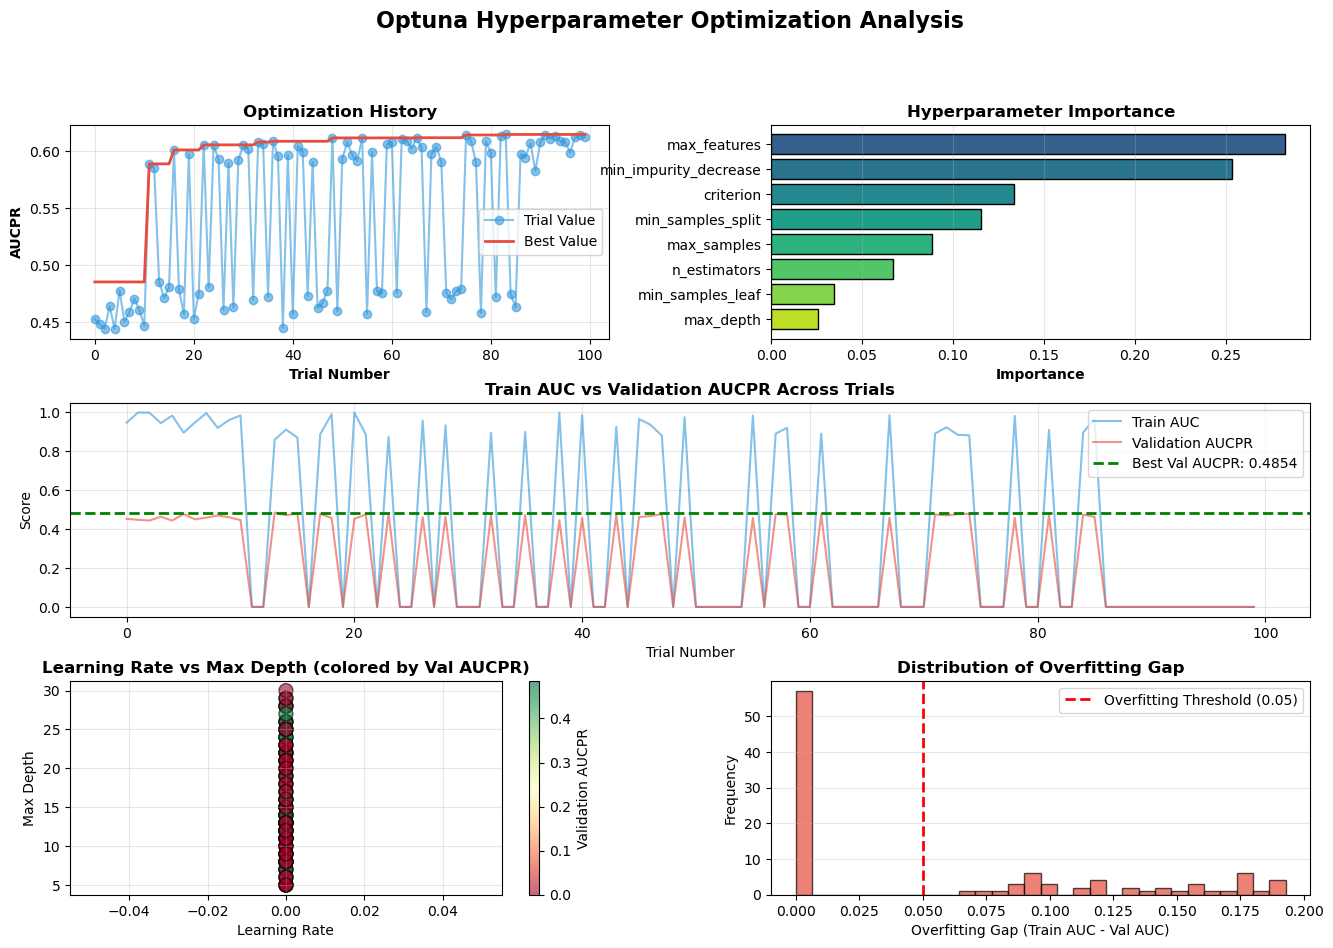

In [16]:
fig_optuna = plt.figure(figsize=(16, 10))
gs_optuna = fig_optuna.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. optimization history
ax1 = fig_optuna.add_subplot(gs_optuna[0, 0])
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value if trial.value is not None else 0 for trial in study.trials]
best_values = [study.best_value if i == 0 else max(study.best_value, max(trial_values[:i+1])) 
               for i in range(len(trial_values))]

ax1.plot(trial_numbers, trial_values, marker='o', alpha=0.6, label='Trial Value', color='#3498db')
ax1.plot(trial_numbers, best_values, linewidth=2, label='Best Value', color='#e74c3c')
ax1.set_xlabel('Trial Number', fontweight='bold')
ax1.set_ylabel('AUCPR', fontweight='bold')
ax1.set_title('Optimization History', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. parameter importance
ax2 = fig_optuna.add_subplot(gs_optuna[0, 1])
try:
    importances = optuna.importance.get_param_importances(study)
    param_names = list(importances.keys())
    importance_values = list(importances.values())
    
    top_n = min(8, len(param_names))
    param_names = param_names[:top_n]
    importance_values = importance_values[:top_n]
    
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(param_names)))
    ax2.barh(range(len(param_names)), importance_values, color=colors, edgecolor='black')
    ax2.set_yticks(range(len(param_names)))
    ax2.set_yticklabels(param_names)
    ax2.set_xlabel('Importance', fontweight='bold')
    ax2.set_title('Hyperparameter Importance', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, axis='x', alpha=0.3)
except:
    ax2.text(0.5, 0.5, 'Not enough trials for importance analysis', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)

# 3. overfitting analysis(AUCPR)
ax3 = fig_optuna.add_subplot(gs_optuna[1, :])
train_aucs = [trial.user_attrs.get('mean_train_auc', 0) for trial in study.trials]
val_aucprs = [trial.user_attrs.get('mean_val_aucpr', 0) for trial in study.trials]
trial_numbers = range(len(study.trials))

ax3.plot(trial_numbers, train_aucs, label='Train AUC', alpha=0.6, color='#3498db')
ax3.plot(trial_numbers, val_aucprs, label='Validation AUCPR', alpha=0.6, color='#e74c3c')
ax3.axhline(y=best_score, color='green', linestyle='--', 
            label=f'Best Val AUCPR: {best_score:.4f}', linewidth=2)
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Score')
ax3.set_title('Train AUC vs Validation AUCPR Across Trials', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Learning Rate vs Max Depth scatter plot
ax4 = fig_optuna.add_subplot(gs_optuna[2, 0])
lr_values = [trial.params.get('learning_rate', 0) for trial in study.trials]
depth_values = [trial.params.get('max_depth', 0) for trial in study.trials]
val_aucprs_scatter = [trial.user_attrs.get('mean_val_aucpr', 0) for trial in study.trials]
scatter = ax4.scatter(lr_values, depth_values, c=val_aucprs_scatter, 
                     cmap='RdYlGn', s=100, alpha=0.6, edgecolors='black')
ax4.set_xlabel('Learning Rate')
ax4.set_ylabel('Max Depth')
ax4.set_title('Learning Rate vs Max Depth (colored by Val AUCPR)', 
              fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='Validation AUCPR')
ax4.grid(True, alpha=0.3)

# 5. Overfitting gap distribution
ax5 = fig_optuna.add_subplot(gs_optuna[2, 1])
overfitting_gaps = [trial.user_attrs.get('overfitting_gap', 0) for trial in study.trials]
ax5.hist(overfitting_gaps, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
ax5.axvline(x=0.05, color='red', linestyle='--', 
            label='Overfitting Threshold (0.05)', linewidth=2)
ax5.set_xlabel('Overfitting Gap (Train AUC - Val AUC)')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of Overfitting Gap', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle('Optuna Hyperparameter Optimization Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

Text(103, 0.5, 'n=103')

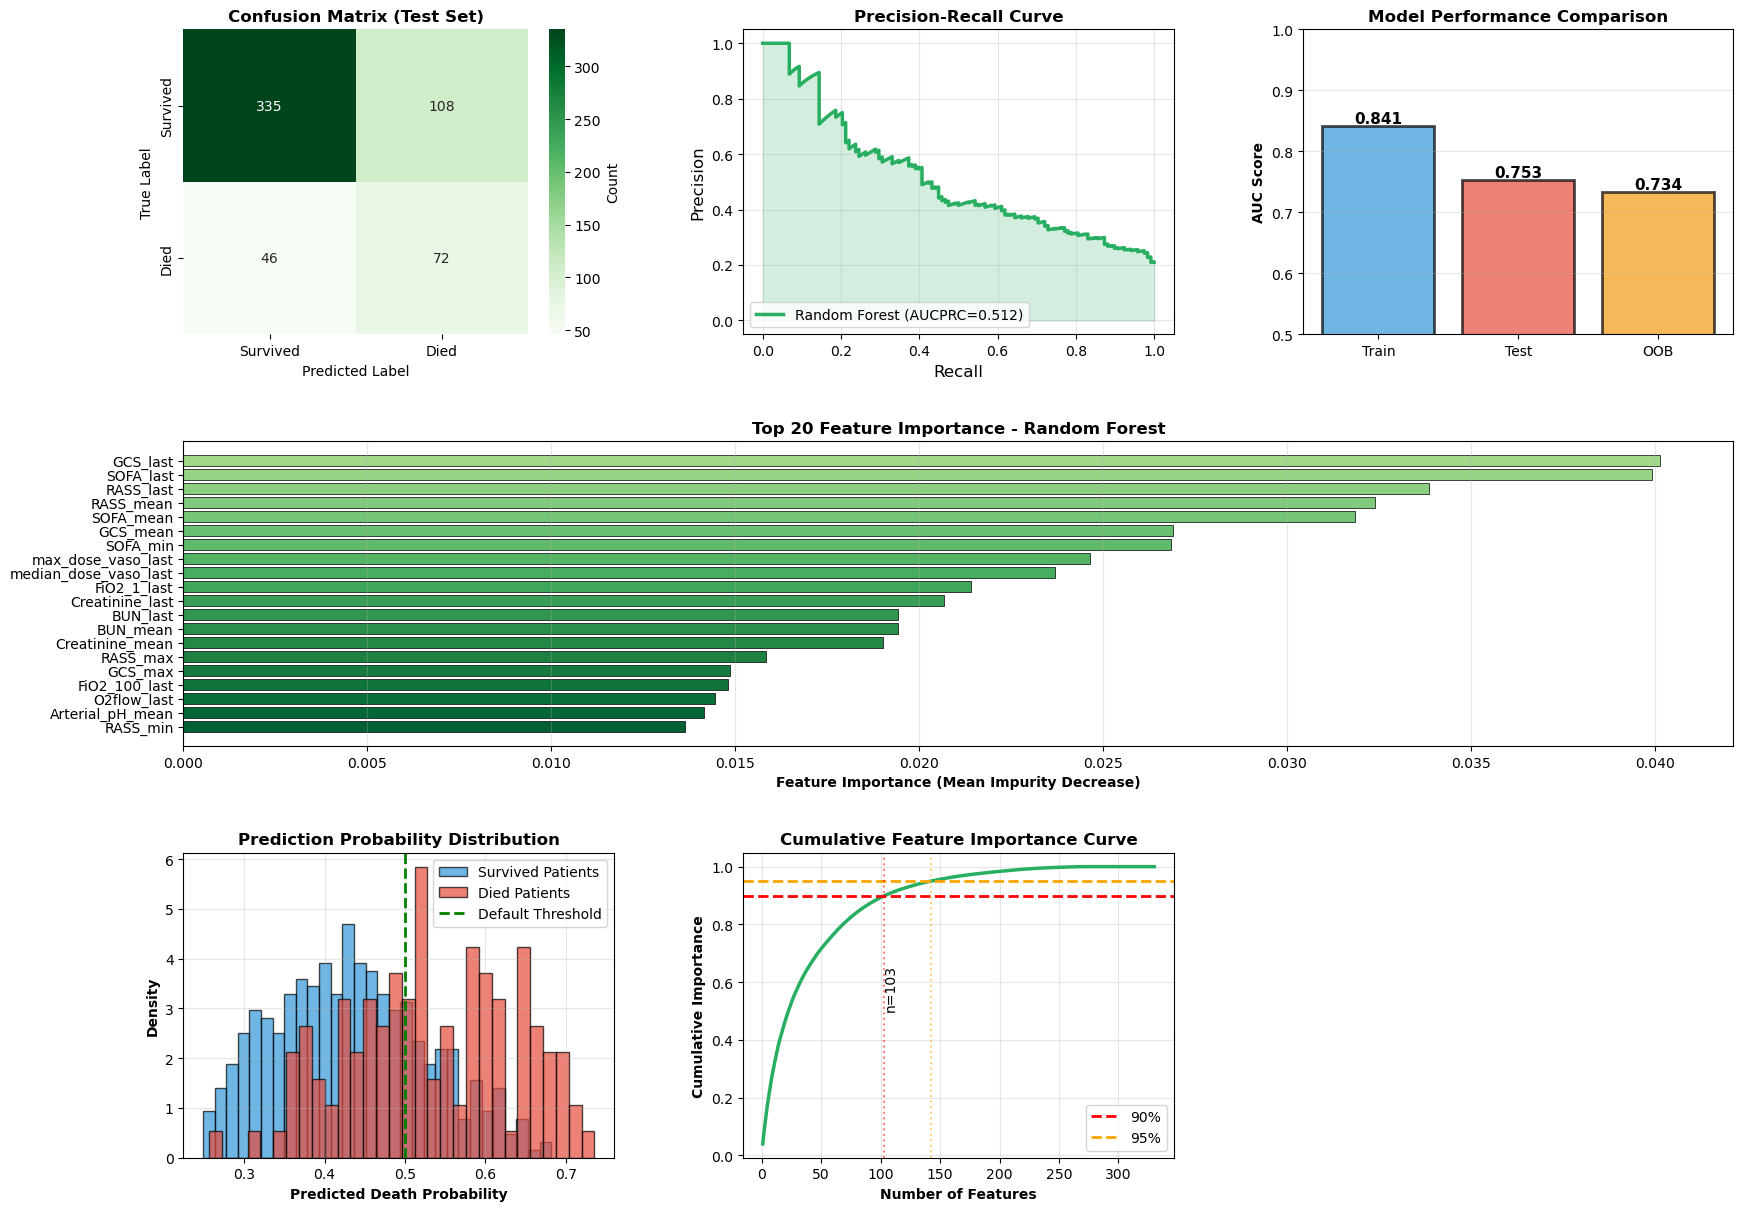

In [17]:
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax1,
            xticklabels=['Survived', 'Died'], 
            yticklabels=['Survived', 'Died'],
            cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# 2. Precision-Recall Curve
ax2 = fig.add_subplot(gs[0, 1])
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
aucprc = average_precision_score(y_test, y_test_proba)

ax2.plot(recall, precision, label=f'Random Forest (AUCPRC={aucprc:.3f})', 
         linewidth=2.5, color='#27ae60')
ax2.fill_between(recall, precision, alpha=0.2, color='#27ae60')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Train vs Test vs OOB Comparison
ax3 = fig.add_subplot(gs[0, 2])
scores = [train_auc, test_auc, best_rf.oob_score_]
labels = ['Train', 'Test', 'OOB']
colors = ['#3498db', '#e74c3c', '#f39c12']
bars = ax3.bar(labels, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('AUC Score', fontweight='bold')
ax3.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax3.set_ylim([0.5, 1.0])
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Top 20 Feature Importance
ax4 = fig.add_subplot(gs[1, :])
top20 = importance_df.head(20)
colors_feat = plt.cm.YlGn(np.linspace(0.4, 0.9, len(top20)))
bars = ax4.barh(range(len(top20)), top20['importance'], color=colors_feat, 
                edgecolor='black', linewidth=0.5)
ax4.set_yticks(range(len(top20)))
ax4.set_yticklabels(top20['feature'])
ax4.set_xlabel('Feature Importance (Mean Impurity Decrease)', fontweight='bold')
ax4.set_title('Top 20 Feature Importance - Random Forest', 
              fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(True, axis='x', alpha=0.3)

# 5. Prediction Probability Distribution
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(y_test_proba[y_test==0], bins=30, alpha=0.7, 
         label='Survived Patients', density=True, color='#3498db', edgecolor='black')
ax5.hist(y_test_proba[y_test==1], bins=30, alpha=0.7, 
         label='Died Patients', density=True, color='#e74c3c', edgecolor='black')
ax5.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Default Threshold')
ax5.set_xlabel('Predicted Death Probability', fontweight='bold')
ax5.set_ylabel('Density', fontweight='bold')
ax5.set_title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Cumulative Feature Importance
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(range(1, len(importance_df)+1), 
         importance_df['cumulative_importance'].values,
         linewidth=2.5, color='#27ae60')
ax6.axhline(y=0.90, color='red', linestyle='--', linewidth=2, label='90%')
ax6.axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95%')
ax6.axvline(x=n_features_90, color='red', linestyle=':', alpha=0.5)
ax6.axvline(x=n_features_95, color='orange', linestyle=':', alpha=0.5)
ax6.set_xlabel('Number of Features', fontweight='bold')
ax6.set_ylabel('Cumulative Importance', fontweight='bold')
ax6.set_title('Cumulative Feature Importance Curve', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.text(n_features_90, 0.5, f'n={n_features_90}', rotation=90, va='bottom')
